# Constructing the datasets

We will use vanilla PyTorch. We will convert audio to spectrograms and use the Emitter as our label of choice (speaker recognition is an important task, it is assumed that in order for a language to form, one needs to be able to identify who is speaking).

In [1]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing

import torch

In [2]:
anno = pd.read_csv('data/annotations.csv')

Let's keep the sample rate of 250_000 Hz but only take the first second of the recording. This can be modified to taking random porition of a file of 1 second duration to improve the results.

Additionally, we will zero pad examples that are less than 1 second.

Let us load a single wave file to take a closer look at the processing we will apply.

In [3]:
recording, _ = librosa.load(f'data/audio/{anno.iloc[0]["File Name"]}', sr=None)

In [4]:
recording.shape

(590671,)

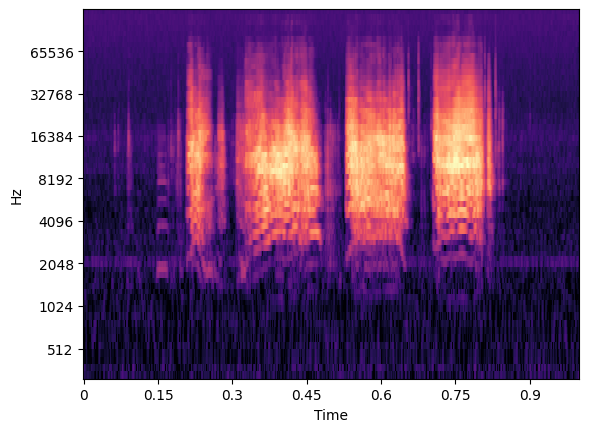

In [ ]:
#  y‑axis: frequency in Hz on a log scale
# With a 250 kHz sampling rate, the true maximum representable frequency is the Nyquist frequency:
# f_max = 250_000 // 2 = 125_000 Hz
spec = librosa.feature.melspectrogram(
    y=recording[:250_000],
    sr=250_000,
    fmin=200,
    fmax=250_000 // 2,
    n_mels=64,
)
spec_db = librosa.power_to_db(spec, ref=np.max)

librosa.display.specshow(
    spec_db,
    sr=250_000,
    x_axis="time",
    y_axis="mel",
    fmin=200,
    fmax=250_000 // 2,
)

In [11]:
anno.head()

,Emitter,File Name
0,216,69809.wav
1,215,71889.wav
2,216,46690.wav
3,230,85411.wav
4,215,45609.wav


In [12]:
emitters = anno.Emitter.unique().tolist()

emitter2idx = {emitter: idx for idx, emitter in enumerate(emitters)}

In [ ]:
# 10 emitters (full is 83 emitters)
len(emitters)

10

In [ ]:
# 1000 of each emitter (1000 x 10 = 10000)
anno.Emitter.value_counts()

Emitter
216    1000
215    1000
230    1000
231    1000
211    1000
111    1000
228    1000
226    1000
220    1000
210    1000
Name: count, dtype: int64

The (full) dataset is unbalanced to a great extent. This is something to keep in mind when considering the metric to use. Limiting the task to for instance the 20 best represented individuals or addressing the class imbalance via oversampling (or some other method) might also be a viable option.

NOTE: in the 10k data, the classes are balanced (see cell above)

Train-Test Split:

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
split = list(skf.split(np.arange(anno.shape[0]), anno.Emitter))[0]

In [16]:
split

(array([   0,    1,    2, ..., 9997, 9998, 9999], shape=(8000,)),
 array([  11,   14,   16, ..., 9979, 9982, 9986], shape=(2000,)))

In [17]:
anno.iloc[split[0]].Emitter.value_counts()

Emitter
216    800
215    800
230    800
231    800
211    800
228    800
226    800
220    800
111    800
210    800
Name: count, dtype: int64

In [26]:
anno.iloc[split[1]].Emitter.value_counts()

Emitter
215    200
230    200
111    200
226    200
231    200
220    200
211    200
210    200
228    200
216    200
Name: count, dtype: int64

In [28]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.examples = df

    def __getitem__(self, index):
        example = self.examples.iloc[index]
        recording, _ = librosa.load(f'data/audio/{example["File Name"]}', sr=None)
        audio = np.zeros((250_000))
        audio[:recording.shape[0]] = recording[:250_000]

        x = librosa.feature.melspectrogram(
            y=audio,
            sr=250_000,
            fmin=200,
            fmax=250_000 // 2,
            n_mels=64,
        )
        y = emitter2idx[example.Emitter]
        return x, y

    def __len__(self):
        return self.examples.shape[0]

In [32]:
train_ds = Dataset(anno.iloc[split[0]])
valid_ds = Dataset(anno.iloc[split[1]])

In [34]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
)

In [35]:
for batch in train_dl: pass
for batch in valid_dl: pass

In [ ]:
# (torch.Size([16, 64, 489]), torch.Size([16]))
batch[0].shape, batch[1].shape # we are on the final batch, there were not enough examples to fill it

(torch.Size([16, 64, 489]), torch.Size([16]))